In [1]:
import sys
import xarray as xr
import datetime

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as mticker
from matplotlib.colors import ListedColormap

import glob
import numpy as np
import pandas as pd

from pathlib import Path
import os


In [61]:
# define mapping function:
def map(x,y,data,vmin,vmax,**karg):    
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=lon0))
    ax.set_extent([lonmapmin, lonmapmax, latmapmin, latmapmax], crs=ccrs.PlateCarree()) 
    if karg['land']:
        ax.add_feature(cfeature.LAND, facecolor = '0.75',zorder=1)
    if karg['coastline']:
            ax.coastlines('10m',zorder=2)
    ax.add_feature(cfeature.RIVERS,facecolor='blue',zorder=3)
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
    gl.xlocator = mticker.FixedLocator(np.arange(lonmapmin-10,lonmapmax+15,10))
#     gl.xformatter = LONGITUDE_FORMATTER
    gl.xlabel_style = {'size': 14, 'color': 'k','rotation':0}
#     gl.yformatter = LATITUDE_FORMATTER
    gl.ylocator = mticker.FixedLocator(np.arange(latmapmin-1,latmapmax+1,5))
    gl.ylabel_style = {'size': 14, 'color': 'gray','rotation':0}

    pp = ax.pcolormesh(x, y, data, 
                        vmin=vmin, vmax=vmax,  # Set max and min values for plotting
                        cmap=karg['palette'], shading='auto',   # shading='auto' to avoid warning
                        transform=ccrs.PlateCarree())  # coords are lat,lon but map if NPS
    if 'level_contour' in karg:  
        matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
        X, Y, masked_data = z_masked_overlap(ax, karg['x_contour'].values, karg['y_contour'].values, karg['data_contour'].values, source_projection=cartopy.crs.Geodetic())    
        cc=ax.contour(X,Y,masked_data,levels=[karg['level_contour']],colors='m',linewidth=4)
        fmt = {}
        plt.clabel(cc, cc.levels, fmt=karg['label_contour'], inline=True, fontsize=10,colors='m')
    if karg['cbar']:
        cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.04])
        h=plt.colorbar(pp, cax=cbar_ax,orientation='horizontal',ax=ax)
        h.ax.tick_params(labelsize=20)
        h.set_label(karg['unit'],fontsize=20)
        cmin,cmax = h.mappable.get_clim()
    else:
        h=[]
    ax.set_title(karg['title'],fontsize=20)
    plt.subplots_adjust(right=0.9,left=0.1,top=0.9,bottom=0.18)
#     plt.savefig(karg['fileout'], dpi=72)
    return ax, h, fig
    
    
def z_masked_overlap(axe, X, Y, Z, source_projection=None):
    """
    for data in projection axe.projection
    find and mask the overlaps (more 1/2 the axe.projection range)
    X, Y either the coordinates in axe.projection or longitudes latitudes
    Z the data
    operation one of 'pcorlor', 'pcolormesh', 'countour', 'countourf'
    if source_projection is a geodetic CRS data is in geodetic coordinates
    and should first be projected in axe.projection
    X, Y are 2D same dimension as Z for contour and contourf
    same dimension as Z or with an extra row and column for pcolor
    and pcolormesh
    return ptx, pty, Z
    """
    if not hasattr(axe, 'projection'):
        return Z
    if not isinstance(axe.projection, cartopy.crs.Projection):
        return Z
    if len(X.shape) != 2 or len(Y.shape) != 2:
        return Z

    if (source_projection is not None and
            isinstance(source_projection, cartopy.crs.Geodetic)):
        transformed_pts = axe.projection.transform_points(
            source_projection, X, Y)
        ptx, pty = transformed_pts[..., 0], transformed_pts[..., 1]
    else:
        ptx, pty = X, Y
    with np.errstate(invalid='ignore'):
        # diagonals have one less row and one less columns
        diagonal0_lengths = np.hypot(
            ptx[1:, 1:] - ptx[:-1, :-1],
            pty[1:, 1:] - pty[:-1, :-1]
        )
        diagonal1_lengths = np.hypot(
            ptx[1:, :-1] - ptx[:-1, 1:],
            pty[1:, :-1] - pty[:-1, 1:]
        )
        to_mask = (
            (diagonal0_lengths > (
                abs(axe.projection.x_limits[1]
                    - axe.projection.x_limits[0])) / 2) |
            np.isnan(diagonal0_lengths) |
            (diagonal1_lengths > (
                abs(axe.projection.x_limits[1]
                    - axe.projection.x_limits[0])) / 2) |
            np.isnan(diagonal1_lengths)
        )
        # TODO check if we need to do something about surrounding vertices
        # add one extra colum and row for contour and contourf
        if (to_mask.shape[0] == Z.shape[0] - 1 and
                to_mask.shape[1] == Z.shape[1] - 1):
            to_mask_extended = np.zeros(Z.shape, dtype=bool)
            to_mask_extended[:-1, :-1] = to_mask
            to_mask_extended[-1, :] = to_mask_extended[-2, :]
            to_mask_extended[:, -1] = to_mask_extended[:, -2]
            to_mask = to_mask_extended
        if np.any(to_mask):
            Z_mask = getattr(Z, 'mask', None)
            to_mask = to_mask if Z_mask is None else to_mask | Z_mask
            Z = ma.masked_where(to_mask, Z)
        return ptx, pty, Z

In [62]:
# which product to map, directories
WHICH=1 # 1: amsr 2: MASIE
# WHICH=3 # 3: SMOS

rawdata_path=Path('/data1/sassie/FTP/satellite/Data/') 
figures_path=Path('/data2/Dropbox/projects/sassie_kd/figures/movies/')
amsrpath=f'{rawdata_path}/seaice_amsr/'
if WHICH==1:
    #AMSR Sea ice ############################################ 
    satpath=amsrpath
    satfigspath=f'{figures_path}/seaice_amsr/'
elif WHICH==2:
    # MASIE
    satpath=f'{rawdata_path}/iceextent_masie/'
    satfigspath=f'{figures_path}/iceextent_masie/'
elif WHICH==3:
    # SMOS
    satpath=f'/data1/sassie/satellite/smos'
    satfigspath=f'{figures_path}/smos/'
        
# create folders locally if don't exist
os.system('mkdir -p '+str(satpath))
os.system('mkdir -p '+str(satfigspath))

0

In [63]:
# load in situ data - individual files are df,
# append those all to give dfall
#  EG just wave glider data
# ... can just use the .csv files from Suzanne for simplicity :)

datadir = '/data1/sassie/FTP/insitu/data/'

prefixes = {'WaveGlider_*','SWIFT*','UTO*'}
prefixes = {'WaveGlider_*'}
files = []
for pre in prefixes:
    files.extend(glob.glob(datadir + pre + '*.csv'))

# Load the files and combine
i = 0
dfall = []
for file in files:
    i+=1
    print(file)
    df = pd.read_csv(file)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[df.Lat > 60]
    df = df[df.Lat < 90]
    df = df[df.Lon > -180]
    df = df[df.Lon < -130]
    
    if i==1:
        dfall = df
    else:
        dfall = dfall.append(df)

/data1/sassie/FTP/insitu/data/WaveGlider_SV3-130.csv
/data1/sassie/FTP/insitu/data/WaveGlider_SV3-247.csv
/data1/sassie/FTP/insitu/data/WaveGlider_SV3-245.csv
/data1/sassie/FTP/insitu/data/WaveGlider_SV3-153.csv


In [64]:
# TSG data
processdir = '/data1/sassie/process/'
tsgfile = processdir + 'sassie_tsg.csv'
dftsg = pd.read_csv(tsgfile, names=['yyyy', 'mm', 'dd', 'HH', 'MM', 'SS', 'Lat', 'Lon','Temperature','Salinity'],
                   parse_dates={ 'Date': [0, 1, 2, 3, 4, 5]})
dftsg['Date'] = pd.to_datetime(dftsg['Date'], format='%Y %m %d %H %M %S')


In [71]:
# plots
CONTOUR_AMSR = False
RES = 150 # dpi of output
# full domain
lon0=-150
lonmapmin=-160
lonmapmax=-140
latmapmin=69
latmapmax=74

# even larger domain
lon0=-145
lonmapmin=-170
lonmapmax=-120
latmapmin=56
latmapmax=80
    
# date range 
base = datetime.date(2022,9,1) 
numdays = 35

# # wave glider august
# # date range 
# base = datetime.date(2022,8,10) 
# numdays = 40
# #region for maps
# lon0=-150
# lonmapmin=-160
# lonmapmax=-134
# latmapmin=68
# latmapmax=75


vmin=24
vmax=28
# which in situ to plot:
INSITU = 1 # 0: none. 1: TSG 2: WG   3: all

date_list = [base + datetime.timedelta(days=x) for x in range(numdays)]


In [72]:

if INSITU==1:
    dfplot = dftsg
    insitu = 'tsg'
elif INSITU==2:
    dfplot = dfall
    insitu='waveglider'
elif INSITU==3:
    dfplot = dftsg.append(dfall)
    insitu = 'all'
elif INSITU==0:
    insitu = 'no-insitu' 
    
if WHICH==1:
    fnsat='AMSR'
    a = cm.get_cmap('Greys',64)
    colors = a(np.linspace(0,1,64))
    cm_sat = ListedColormap(colors)
    
    # 
    a = cm.get_cmap('Blues_r',64)
    colors = a(np.linspace(0,1,64))
    cm_sat = ListedColormap(colors)
if WHICH==2:
    # for masie, open the lat/lon grid only once
    ds_masie = xr.open_dataset(f'{satpath}/masie_lat_lon_4km.nc')
    fnsat='MASIE'
    a = cm.get_cmap('Greys_r',64)
    colors = a(np.linspace(0,1,2))
    cm_sat = ListedColormap(colors)
if WHICH==3:
    fnsat='SMOS'
    cm_sat = cm.get_cmap('viridis',64)
    
    
os.system(f'mkdir -p {figures_path}/{fnsat}_{insitu}/')
os.system(f'rm {figures_path}/{fnsat}_{insitu}/*png')

months=[]
for time in date_list:
    year = time.year
    month = time.month
    day=time.day


    # define tstop (now) and tstart (range of in situ dates to plot on this satellite map, eg last 2 days)
#         time = datetime.date(year,month,day)
    doy = time.timetuple().tm_yday
    dtplot = 2 # past # of days to plot
    tstop = time
    tstart = tstop - datetime.timedelta(dtplot) # might need to subtract 1
    #thisdate = datetime.datetime.strptime(tstop,'%Y-%m-%d')

    # select the in situ data to plot in this time range
    dfpl = dfplot.where((dfplot.Date>tstart.strftime('%Y-%m-%d')) & (dfplot.Date<tstop.strftime('%Y-%m-%d')))


    if (WHICH==1) or (CONTOUR_AMSR==True):
        filename_sat=f'AMSR_U2_L3_SeaIce12km_B04_{year}{month:02}{day:02}.he5'
        if os.path.exists(f'{amsrpath}/{filename_sat}'):
            dsc = xr.open_dataset(f'{amsrpath}/{filename_sat}',group='HDFEOS/GRIDS/NpPolarGrid12km')
            dsd = xr.open_dataset(f'{amsrpath}/{filename_sat}',group='HDFEOS/GRIDS/NpPolarGrid12km/Data Fields')
            if WHICH==1:
                ax, h, fig = map(dsc.lon,dsc.lat,dsd.SI_12km_NH_ICECON_DAY.squeeze(),0,100,
                    palette=cm_sat,unit='',land=True,coastline=True,cbar=False,
                    #level_contour=15,label_contour=datestr_ice,x_contour=dsc.lon,y_contour=dsc.lat,data_contour=dsd.SI_12km_NH_ICECON_DAY.squeeze(),
                    #title=f'{year}/{month:02}/{day:02}',
                    title=datetime.datetime.strftime(time,'%B %d'),
                    fileout=f'{satfigspath}/sic_amsr_{year}{month:02}{day:02}.png')

    if WHICH==2:            
        filename_sat=f'masie_all_r00_v01_{year}{doy}_4km.nc'
        if os.path.exists(f'{satpath}/{filename_sat}'):
            ds = xr.open_dataset(f'{satpath}/{filename_sat}')
            ax, h, fig = map(ds_masie.longitude,ds_masie.latitude,ds.sea_ice_extent.squeeze()[:-1,:-1],2.5,3.5,
                palette=cm_sat,unit='',land=True,coastline=True,cbar=False,
                title=f'MASIE ice extent - {year}/{month:02}/{day:02}',
                fileout=f'{satfigspath}/iceextent_masie_{year}{month:02}{day:02}.png')
        else:
            print(f'{satpath}/{filename_sat} - no file')
    elif WHICH==3:
        filename_sat=f'{year}-{month:02}-{day:02}-L3A-AS-v700-arctic.nc'
        ds = xr.open_dataset(f'{satpath}/{filename_sat}')
        ax, h, fig = map(ds.longitude,ds.latitude,ds.ACARD_SSS.squeeze(),20,30,
                palette='jet',unit='psu',land=True,coastline=True,cbar=True,
                level_contour=15,label_contour='',x_contour=dsc.lon,y_contour=dsc.lat,data_contour=dsd.SI_12km_NH_ICECON_DAY.squeeze(),
                title=f'SSS SMOS - {year}/{month:02}/{day:02}',
                fileout=f'{satfigspath}/smos_{year}{month:02}{day:02}.png')
          
    if INSITU>0:
            
#         sc = ax.scatter(dfpl['Lon'], dfpl['Lat'], c=dfpl['Salinity'],
#               transform=ccrs.PlateCarree(),
#                 vmin=vmin, vmax=vmax)
        sc = ax.scatter(dfpl['Lon'], dfpl['Lat'], c='r',
              transform=ccrs.PlateCarree())
#         fig.colorbar(sc, fraction=.05, ax=ax, shrink=1, location='bottom')

    fileout = f'{figures_path}/{fnsat}_{insitu}/{fnsat}_{insitu}_{year}{month:02}{day:02}_{RES}dpi.png'
    #print(f'saving {fileout}')
    plt.savefig(fileout, dpi=RES, transparent=True, facecolor='white',  bbox_inches='tight')
    plt.close()

In [73]:
# make movie from PNGs using "convert"
# insitu = 'no-insitu' 
# fnsat = 'AMSR'
os.system(f'convert -loop 0 -delay 30 {figures_path}/{fnsat}_{insitu}/{fnsat}_{insitu}_*_{RES}dpi.png {figures_path}/{fnsat}_{insitu}_{RES}dpi_movie.gif')

0

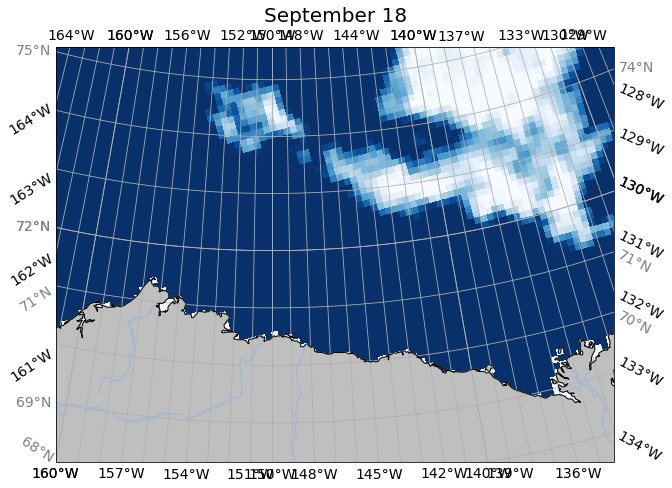

In [37]:
month=9
day=15

filename_sat=f'AMSR_U2_L3_SeaIce12km_B04_{year}{month:02}{day:02}.he5'
dsc = xr.open_dataset(f'{amsrpath}/{filename_sat}',group='HDFEOS/GRIDS/NpPolarGrid12km')
dsd = xr.open_dataset(f'{amsrpath}/{filename_sat}',group='HDFEOS/GRIDS/NpPolarGrid12km/Data Fields')
            
ax, h, fig = map(dsc.lon,dsc.lat,dsd.SI_12km_NH_ICECON_DAY.squeeze(),0,100,
                    palette=cm_sat,unit='',land=True,coastline=True,cbar=False,
                    #level_contour=15,label_contour=datestr_ice,x_contour=dsc.lon,y_contour=dsc.lat,data_contour=dsd.SI_12km_NH_ICECON_DAY.squeeze(),
                    #title=f'{year}/{month:02}/{day:02}',
                    title=datetime.datetime.strftime(time,'%B %d'),
                    fileout=f'{satfigspath}/sic_amsr_{year}{month:02}{day:02}.png')
gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
gl.xlocator = mticker.FixedLocator(np.arange(lonmapmin-10,lonmapmax+15,1))
#     gl.xformatter = LONGITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'k','rotation':0}
#     gl.yformatter = LATITUDE_FORMATTER
gl.ylocator = mticker.FixedLocator(np.arange(latmapmin-1,latmapmax+1,1))
gl.ylabel_style = {'size': 14, 'color': 'gray','rotation':0}

  

In [69]:
months=[]
for time in date_list:
    year = time.year
    month = time.month
    day=time.day
    months.append(month)
months = np.unique(months)
print(months)
for month in months:
    os.system(f'convert -loop 0 -delay 20 {figures_path}/{fnsat}_{insitu}/{fnsat}_{insitu}_{year}{month:02}*_{RES}dpi.png {figures_path}/{fnsat}_{insitu}_{year}{month:02}_{RES}dpi_movie.gif')


[ 6  7  8  9 10]


In [ ]:
# amsr colorbar

ax, h, fig = map(dsc.lon,dsc.lat,dsd.SI_12km_NH_ICECON_DAY.squeeze(),0,100,
                palette=cm_sat,unit='',land=True,coastline=True,cbar=True,
                title=f'{year}/{month:02}/{day:02}',
                fileout=f'{satfigspath}/sic_amsr_COLORBAR.png')
plt.savefig(f'{figures_path}/sic_amsr_COLORBAR.png', dpi=72, transparent=False, facecolor='white')

In [ ]:
# plot all
ax, h, fig = map(dsc.lon,dsc.lat,0*dsd.SI_12km_NH_ICECON_DAY.squeeze(),0,100,
                palette=cm_sat,unit='',land=True,coastline=True,cbar=False,
                title=f'SSS from ship, drifters, and Wave Gliders',
                fileout='')
sc = ax.scatter(dfall['Lon'], dfall['Lat'], c=dfall['Salinity'],
      transform=ccrs.PlateCarree(),
        vmin=vmin, vmax=vmax)
sc2 = ax.scatter(dftsg['Lon'], dftsg['Lat'], c=dftsg['Salinity'],
      transform=ccrs.PlateCarree(),
        vmin=vmin, vmax=vmax)
fig.colorbar(sc, fraction=.05, ax=ax, shrink=1, location='bottom')
fileout = f'{figures_path}/SSS_all.png'
plt.savefig(fileout, dpi=120, transparent=False, facecolor='white')
    

In [ ]:
ax, h, fig = map(dsc.lon,dsc.lat,0*dsd.SI_12km_NH_ICECON_DAY.squeeze(),0,100,
                palette=cm_sat,unit='',land=True,coastline=True,cbar=False,
                title=f'SST from ship, drifters, and Wave Gliders',
                fileout='')
sc = ax.scatter(dfall['Lon'], dfall['Lat'], c=dfall['Temperature'],
      transform=ccrs.PlateCarree(),cmap='plasma',
        vmin=-2, vmax=4)
sc2 = ax.scatter(dftsg['Lon'], dftsg['Lat'], c=dftsg['Temperature'],
      transform=ccrs.PlateCarree(),cmap='plasma',
        vmin=-2, vmax=4)
fig.colorbar(sc, fraction=.05, ax=ax, shrink=1, location='bottom')
fileout = f'{figures_path}/SST_all.png'
plt.savefig(fileout, dpi=120, transparent=False, facecolor='white')
    

In [39]:
## smos movies
WHICH=3 # 3: SMOS
# plot   
INSITU = 0 # 0: none 1: TSG 2: WG 3: all
if INSITU==1:
    dfplot = dftsg
    insitu = 'tsg'
    # date range 
    base = datetime.date(2022,9,5) 
    numdays = 30
    
    # full domain
    lon0=-150
    lonmapmin=-160
    lonmapmax=-140
    latmapmin=69
    latmapmax=74
    
    vmin=24
    vmax=28
elif INSITU==2:
    dfplot = dfall
    insitu='waveglider'
    # date range 
    base = datetime.date(2022,8,15) 
    numdays = 50
    #region for maps
    lon0=-150
    # wave glider august
    lonmapmin=-156
    lonmapmax=-142
    latmapmin=70
    latmapmax=73.5
    vmin=24
    vmax=28
if INSITU==3:
    dfplot = dftsg.append(dfall)
    insitu = 'all'
    # date range 
    base = datetime.date(2022,8,5) 
    numdays = 50
    
    # full domain
    lon0=-150
    lonmapmin=-160
    lonmapmax=-140
    latmapmin=69
    latmapmax=74
    
    vmin=24
    vmax=28
    
date_list = [base + datetime.timedelta(days=x) for x in range(numdays)]





if WHICH==1:
    fnsat='AMSR'
    a = cm.get_cmap('Greys',64)
    colors = a(np.linspace(0,1,64))
    cm_sat = ListedColormap(colors)
if WHICH==2:
    # for masie, open the lat/lon grid only once
    ds_masie = xr.open_dataset(f'{satpath}/masie_lat_lon_4km.nc')
    fnsat='MASIE'
    a = cm.get_cmap('Greys_r',64)
    colors = a(np.linspace(0,1,2))
    cm_sat = ListedColormap(colors)
    
    
if INSITU:
    os.system(f'mkdir -p {figures_path}/{fnsat}_{insitu}/')
    # os.system(f'rm {figures_path}/{fnsat}_{insitu}/*png')
else:
    os.system(f'mkdir -p {figures_path}/{fnsat}_{insitu}/')

for time in date_list:
    year = time.year
    month = time.month
    day=time.day


    # define tstop (now) and tstart (range of in situ dates to plot on this satellite map, eg last 2 days)
#         time = datetime.date(year,month,day)
    doy = time.timetuple().tm_yday
    dtplot = 2 # past # of days to plot
    tstop = time
    tstart = tstop - datetime.timedelta(dtplot) # might need to subtract 1
    #thisdate = datetime.datetime.strptime(tstop,'%Y-%m-%d')

    # select the in situ data to plot in this time range
    dfpl = dfplot.where((dfplot.Date>tstart.strftime('%Y-%m-%d')) & (dfplot.Date<tstop.strftime('%Y-%m-%d')))


    if WHICH==1:
        filename_sat=f'AMSR_U2_L3_SeaIce12km_B04_{year}{month:02}{day:02}.he5'
        if os.path.exists(f'{satpath}/{filename_sat}'):
            dsc = xr.open_dataset(f'{satpath}/{filename_sat}',group='HDFEOS/GRIDS/NpPolarGrid12km')
            dsd = xr.open_dataset(f'{satpath}/{filename_sat}',group='HDFEOS/GRIDS/NpPolarGrid12km/Data Fields')

            ax, h, fig = map(dsc.lon,dsc.lat,dsd.SI_12km_NH_ICECON_DAY.squeeze(),0,100,
                palette=cm_sat,unit='',land=True,coastline=True,cbar=False,
                #level_contour=15,label_contour=datestr_ice,x_contour=dsc.lon,y_contour=dsc.lat,data_contour=dsd.SI_12km_NH_ICECON_DAY.squeeze(),
                title=f'{year}/{month:02}/{day:02}',
                fileout=f'{satfigspath}/sic_amsr_{year}{month:02}{day:02}.png')

    elif WHICH==2:            
        filename_sat=f'masie_all_r00_v01_{year}{doy}_4km.nc'
        if os.path.exists(f'{satpath}/{filename_sat}'):
            ds = xr.open_dataset(f'{satpath}/{filename_sat}')
            ax, h, fig = map(ds_masie.longitude,ds_masie.latitude,ds.sea_ice_extent.squeeze()[:-1,:-1],2.5,3.5,
                palette=cm_sat,unit='',land=True,coastline=True,cbar=False,
                title=f'MASIE ice extent - {year}/{month:02}/{day:02}',
                fileout=f'{satfigspath}/iceextent_masie_{year}{month:02}{day:02}.png')
        else:
            print(f'{satpath}/{filename_sat} - no file')
    sc = ax.scatter(dfpl['Lon'], dfpl['Lat'], c=dfpl['Salinity'],
          transform=ccrs.PlateCarree(),
            vmin=vmin, vmax=vmax)
    fig.colorbar(sc, fraction=.05, ax=ax, shrink=1, location='bottom')

    fileout = f'{figures_path}/{fnsat}_{insitu}/{fnsat}_{insitu}_{year}{month:02}{day:02}.png'
    plt.savefig(fileout, dpi=72, transparent=False, facecolor='white')
    plt.close()


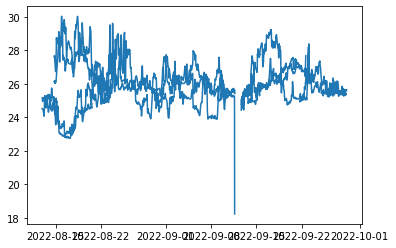

In [50]:
plt.plot(dfall.Date.where(dfall.Salinity>15),dfall.Salinity.where(dfall.Salinity>15))

In [48]:
dfall

,Date,Lat,Lon,Temperature,Salinity,Depth
0,2022-08-14 19:21:19,71.070,-151.844,3.446,26.122,0.25
1,2022-08-14 19:51:19,71.073,-151.872,3.539,26.110,0.25
2,2022-08-14 20:21:20,71.076,-151.898,3.607,26.184,0.25
3,2022-08-14 20:51:20,71.080,-151.924,3.632,26.064,0.25
4,2022-08-14 21:21:19,71.084,-151.950,3.637,26.051,0.25
...,...,...,...,...,...,...
2137,2022-09-29 04:10:43,73.337,-150.896,-1.387,0.007,1.00
2138,2022-09-29 04:40:43,73.380,-150.829,-1.487,0.007,1.00
2139,2022-09-29 05:10:43,73.433,-150.704,-1.461,0.007,1.00
2140,2022-09-29 05:40:43,73.476,-150.581,-1.339,0.007,1.00
